# Assignment

Source: https://mlcogup.github.io/idl2017/ass1.html

In [103]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

import tensorflow as tf

In [104]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [105]:
mnist.train.images.shape, mnist.test.images.shape, mnist.validation.images.shape

((55000, 784), (10000, 784), (5000, 784))

# Building a classification model

In [106]:
# Visualize 9 mnist digits, very hard coded, ugh
def show9(res):
    for i in range(9):
        img = mnist.test.images[res][i].reshape([28, 28])
        lab = mnist.test.labels[res][i]
        lab = list(lab).index(1.)

        plt.subplot(3,3,i+1)
        plt.imshow(img, cmap='gray', interpolation='none')
        plt.title("Class {}".format(lab))
        
    
def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

In [107]:
# From Aylien's blog https://github.com/AYLIEN/gan-intro/blob/master/gan.py

def linear(input, output_dim, scope=None, stddev=1.0):
    with tf.variable_scope(scope or 'linear'):
        with tf.variable_scope('weights'):
            w = tf.get_variable(
                'w',
                [input.get_shape()[1], output_dim],
                initializer=tf.random_normal_initializer(stddev=stddev)
            )
            variable_summaries(w)
        with tf.variable_scope('bias'):
            b = tf.get_variable(
                'b',
                [output_dim],
                initializer=tf.constant_initializer(0.5)
            )
            variable_summaries(b)
        return tf.matmul(input, w) + b, w, b


In [132]:
def classify_mnist():
    train_inputs = tf.placeholder(tf.float32, shape=[None, 784])
    train_outputs = tf.placeholder(tf.float32, shape=[None, 10])

    with tf.variable_scope('G'):
        layer_next, _, _ = linear(train_inputs, 10, 'd0', stddev=0.1)

    predicted = tf.nn.softmax(layer_next)

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=train_outputs, logits=layer_next)
    cross_entropy = tf.reduce_mean(cross_entropy)

    # Metrics
    correct_prediction = tf.equal(tf.argmax(predicted, 1), tf.argmax(train_outputs, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    return train_inputs, train_outputs, cross_entropy, accuracy, predicted, correct_prediction

In [112]:
def my_optimize(sess, train, Xs, Ys, loss, name='train', steps=1000, optimizer=tf.train.GradientDescentOptimizer(0.5), dict={}, batch_size=100):
    train_step = optimizer.minimize(loss)
    
    # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('mnist_logs/%s' % name, sess.graph)
    
    for g, v in optimizer.compute_gradients(loss):
        #tf.summary.scalar("grad_{}".format(v.name), tf.norm(g))
        #merged = tf.Print(merged, [tf.norm(g)], message="grad_{}".format(v.name))
        pass
    
    sess.run(tf.global_variables_initializer())

    for i in range(steps):
        batch_xs, batch_ys = train.next_batch(batch_size)
        dict = dict.copy()# Avoid getting the keys from a different graph
        dict[Xs] = batch_xs
        dict[Ys] = batch_ys
        summary, _ = sess.run([merged, train_step], feed_dict=dict)
        train_writer.add_summary(summary, i)
        
    train_writer.close()

In [133]:
g = tf.Graph()
with g.as_default():
    with tf.Session() as sess:
        Xs, Ys, loss, accuracy, prediction, correct_prediction = classify_mnist()
    
        my_optimize(sess, mnist.train, Xs, Ys, loss, steps=10000, name='train-2')
        
        # Testing accuracy
        acc = sess.run(accuracy, feed_dict={Xs: mnist.test.images, Ys: mnist.test.labels})
        print acc
        
        res = sess.run(correct_prediction, feed_dict={Xs: mnist.test.images, Ys: mnist.test.labels})

0.9233


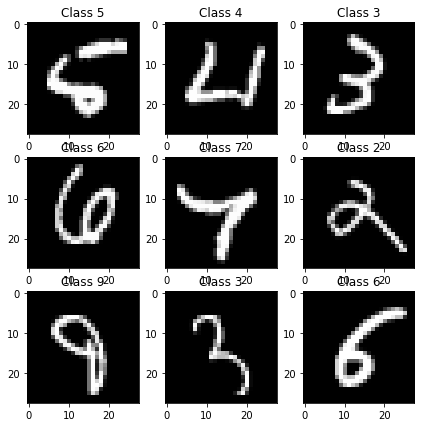

In [134]:
show9(~res)

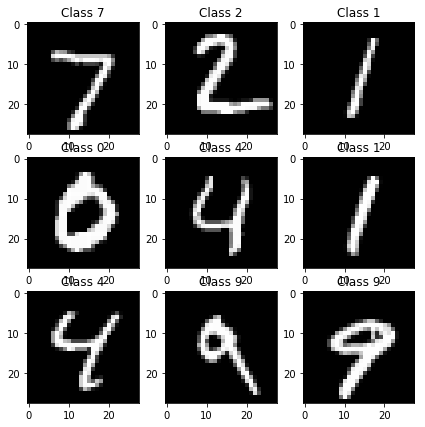

In [135]:
show9(res)

## MNIST with a hidden layer (and more)

In [139]:
def classify_mnist_hidden(beta=0.0, use_relu=None, hidden_sizes=[20]):
    train_inputs = tf.placeholder(tf.float32, shape=[None, 784])
    train_outputs = tf.placeholder(tf.float32, shape=[None, 10])

    with tf.variable_scope('G'):
        
        with tf.variable_scope('train_inputs'):
            variable_summaries(train_inputs)
        
        layer_next = train_inputs
        
        for ix, hidden_size in enumerate(hidden_sizes):
            layer_next, w1, _ = linear(layer_next, hidden_size, 'd%d' % ix, stddev=0.1)
            if use_relu:
                layer_next = tf.nn.relu(layer_next, 'd%d_2' % ix)

        layer_next, w2, _ = linear(layer_next, 10, 'd_out', stddev=0.1)

        predicted = tf.nn.softmax(layer_next)

        l2_loss = (tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2)) * beta
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=train_outputs, logits=layer_next)
        # Average cross_entropy
        cross_entropy = tf.reduce_mean(cross_entropy)
    
        with tf.variable_scope('l2_loss'):
            variable_summaries(l2_loss)
        
        with tf.variable_scope('cross_entropy'):
            variable_summaries(cross_entropy)

        with tf.variable_scope('predicted'):
            variable_summaries(predicted)
            
    # Metrics
    correct_prediction = tf.equal(tf.argmax(predicted, 1), tf.argmax(train_outputs, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    return train_inputs, train_outputs, cross_entropy+l2_loss, accuracy, predicted, correct_prediction

In [140]:
g = tf.Graph()
with g.as_default():
    with tf.Session() as sess:
        Xs, Ys, loss, accuracy, prediction, correct_prediction = classify_mnist_hidden()
    
        my_optimize(sess, mnist.train, Xs, Ys, loss, steps=10000, name='train-34',
                    optimizer=tf.train.GradientDescentOptimizer(0.05))
        
        # Testing accuracy
        acc = sess.run(accuracy, feed_dict={Xs: mnist.test.images, Ys: mnist.test.labels})
        print acc

0.9207


As can be seen below, the addition of a relu to the network improves the performance:

In [141]:
g = tf.Graph()
with g.as_default():
    with tf.Session() as sess:
        Xs, Ys, loss, accuracy, prediction, correct_prediction = classify_mnist_hidden(use_relu=True)

        my_optimize(sess, mnist.train, Xs, Ys, loss, steps=10000, name='train-34',
                    optimizer=tf.train.GradientDescentOptimizer(0.05))
        
        # Testing accuracy
        acc = sess.run(accuracy, feed_dict={Xs: mnist.test.images, Ys: mnist.test.labels})
        print acc

0.9484


In [142]:
g = tf.Graph()
with g.as_default():
    with tf.Session() as sess:
        Xs, Ys, loss, accuracy, prediction, correct_prediction = classify_mnist_hidden(use_relu=True, hidden_sizes=[50])
    
        my_optimize(sess, mnist.train, Xs, Ys, loss, steps=10000, name='train-34',
                    optimizer=tf.train.GradientDescentOptimizer(0.05))
        
        # Testing accuracy
        acc = sess.run(accuracy, feed_dict={Xs: mnist.test.images, Ys: mnist.test.labels})
        print acc

0.9597


In [143]:
g = tf.Graph()
with g.as_default():
    with tf.Session() as sess:
        Xs, Ys, loss, accuracy, prediction, correct_prediction = classify_mnist_hidden(use_relu=True, hidden_sizes=[512])
    
        my_optimize(sess, mnist.train, Xs, Ys, loss, steps=10000, name='train-34',
                    optimizer=tf.train.GradientDescentOptimizer(0.05))
        
        # Testing accuracy
        acc = sess.run(accuracy, feed_dict={Xs: mnist.test.images, Ys: mnist.test.labels})
        print acc

0.9715


In [147]:
g = tf.Graph()
with g.as_default():
    with tf.Session() as sess:
        Xs, Ys, loss, accuracy, prediction, correct_prediction = classify_mnist_hidden(use_relu=True, hidden_sizes=[512, 512])
    
        my_optimize(sess, mnist.train, Xs, Ys, loss, steps=10000, name='train-34',
                    optimizer=tf.train.GradientDescentOptimizer(0.05))
        
        # Testing accuracy
        acc = sess.run(accuracy, feed_dict={Xs: mnist.test.images, Ys: mnist.test.labels})
        print acc
        
        res = sess.run(correct_prediction, feed_dict={Xs: mnist.test.images, Ys: mnist.test.labels})

0.9757


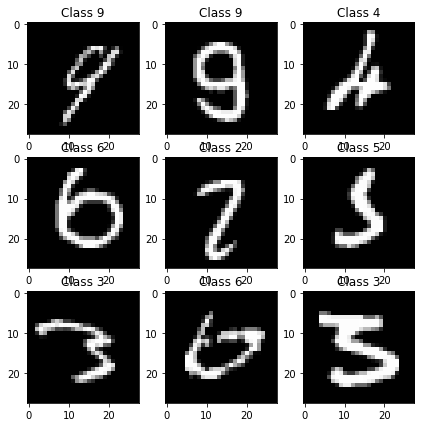

In [148]:
show9(~res)

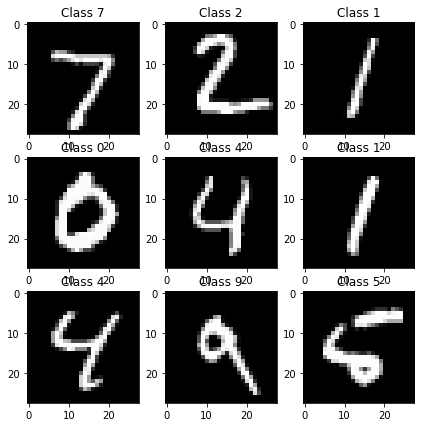

In [149]:
show9(res)

Example of multi-layer network in Keras:

https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb